In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


In [2]:
df=pd.read_csv('D:\\INSEA\\Stage PFA\\Stage Ministère de finance\\data\\tourism\\TES_with_feuters.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.asfreq('MS')  # MS = Month Start
df = df.sort_index()
df['TES']=df['TES'].replace(0,1)

In [3]:
for i in range(6):
    df[f"TES_lag_{i+1}"]=df['TES'].shift(i+1)

df.dropna(inplace=True)

In [15]:
split=22
df_ts=df['TES']
train_ts = df_ts[:len(df_ts) - split]
hw_model = ExponentialSmoothing(train_ts, trend='add', seasonal='add', seasonal_periods=12).fit()
hw_features = pd.DataFrame({'HW_Level': hw_model.level, 'HW_Trend': hw_model.trend, 'HW_Season': hw_model.season})
residuals = hw_model.fittedvalues - train_ts
n_forecast = split

# Get the last components from training
last_level = hw_model.level[-1]
last_trend = hw_model.trend[-1]
seasonality = hw_model.season[-12:]  # seasonal_periods = 12
forecast_index = pd.date_range(train_ts.index[-1] + pd.DateOffset(months=1), periods=n_forecast, freq='MS')
# Build forecasted components manually
future_levels = [last_level + (i + 1) * last_trend for i in range(n_forecast)]
future_trends = [last_trend] * n_forecast
future_seasonality = [seasonality[i % 12] for i in range(n_forecast)]
#future_residuals = [0] * n_forecast  # Assuming unknown error = 0

hw_features_test = pd.DataFrame({
    'HW_Level': future_levels,
    'HW_Trend': future_trends,
    'HW_Season': future_seasonality,
    # 'HW_Residual': future_residuals
}, index=forecast_index)

hw_features = pd.concat([hw_features, hw_features_test])
hw_features.index = hw_features.index.tz_localize(None)
# Ensure both DataFrames have timezone-naive indexes before joining
df.index = df.index.tz_localize(None)
hw_features.index = hw_features.index.tz_localize(None)
# Join these new features with our main feature set
df = df.join(hw_features, how='left')
print("Holt-Winters components added as features.")


Holt-Winters components added as features.


C:\Users\masta\AppData\Local\Temp\ipykernel_29448\195518023.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_level = hw_model.level[-1]
C:\Users\masta\AppData\Local\Temp\ipykernel_29448\195518023.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  last_trend = hw_model.trend[-1]
C:\Users\masta\AppData\Local\Temp\ipykernel_29448\195518023.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  future_seasonality = [seasonality

In [4]:
l=list(df.columns)
l.remove('TES')
l

['marrakech_lag_1',
 'review_count',
 'NSI',
 'is_pandemic',
 'TES_lag_1',
 'TES_lag_2',
 'TES_lag_3',
 'TES_lag_4',
 'TES_lag_5',
 'TES_lag_6']

In [5]:
df

,TES,marrakech_lag_1,review_count,NSI,is_pandemic,TES_lag_1,TES_lag_2,TES_lag_3,TES_lag_4,TES_lag_5,TES_lag_6
date,,,,,,,,,,,
2010-08-01,404345.0,56.0,10.0,0.700,0,509173.0,431246.0,430974.0,432338.0,437338.0,327017.0
2010-09-01,393909.0,53.0,30.0,0.667,0,404345.0,509173.0,431246.0,430974.0,432338.0,437338.0
2010-10-01,488256.0,56.0,116.0,0.690,0,393909.0,404345.0,509173.0,431246.0,430974.0,432338.0
2010-11-01,372583.0,53.0,4.0,1.000,0,488256.0,393909.0,404345.0,509173.0,431246.0,430974.0
2010-12-01,391648.0,49.0,5.0,1.000,0,372583.0,488256.0,393909.0,404345.0,509173.0,431246.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-01,784192.0,82.0,2188.0,0.068,0,720467.0,871449.0,699434.0,829406.0,860187.0,683375.0
2025-01-01,624848.0,78.0,1692.0,0.078,0,784192.0,720467.0,871449.0,699434.0,829406.0,860187.0
2025-02-01,761377.0,84.0,1979.0,0.079,0,624848.0,784192.0,720467.0,871449.0,699434.0,829406.0


In [8]:
# Préparer données
#alphas = np.logspace(-3, 3, 50)
# Expanding window avec contraintes réelles
def forecast(df, target='TES', test=18):
    l=list(df.columns)
    l.remove('TES')
    feats = l
    train_end = len(df) - test
    preds_r,preds_x,preds_f, acts , dates = [],[], [] ,[] ,[]
    feats_f=['marrakech_lag_1','review_count','NSI','is_pandemic']#,'HW_Level','HW_Trend','HW_Season']
    for i in range(test):
        # Train
        print('='*40,"le test némero ",i+1,'='*40)
        train = df.iloc[:train_end + i]
        X_train, y_train = train[feats], train[target]
        X_train_f = train[feats_f]
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        
        #meilleur=optimize_hyperparameters(X_train, y_train)
        # ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
        # ridge_cv.fit(X_train_scaled, y_train)
        # print(f"\nMeilleur alpha trouvé: {ridge_cv.alpha_:.4f}")
        ridge = Ridge(alpha=0.4618,random_state=42)
        ridge.fit(X_train_scaled, y_train)
        model_f = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1
        )
        model_f.fit(X_train_f, y_train)
        model_x = xgb.XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.9,
        random_state=42,
        objective='reg:squarederror',
        n_jobs=-1
        )
        model_x.fit(X_train_f, y_train)

        # Test avec contrainte réelle
        test_row = df.iloc[[train_end + i]][feats].copy()
        test_row_scaled = scaler.transform(test_row)

        test_row = df.iloc[train_end + i][feats].copy()
        test_row_f = df.iloc[train_end + i][feats_f].copy()

        pred_x = model_x.predict(pd.DataFrame([test_row_f]))[0]
        pred_f = model_f.predict(pd.DataFrame([test_row_f]))[0]
        pred_ridge = ridge.predict(test_row_scaled)[0]
        preds_r.append(pred_ridge)
        preds_f.append(pred_f)
        preds_x.append(pred_x)
        acts.append(df.iloc[train_end + i][target])
        dates.append(df.index[train_end + i])
    
    # Métriques
    mae_r = mean_absolute_error(acts, preds_r)
    rmse_r = np.sqrt(mean_squared_error(acts, preds_r))
    r2_r = r2_score(acts, preds_r)
    mape_r = 100 * np.mean(np.abs((np.array(acts) - np.array(preds_r)) / np.array(acts)))

    mae_f = mean_absolute_error(acts, preds_f)
    rmse_f = np.sqrt(mean_squared_error(acts, preds_f))
    r2_f = r2_score(acts, preds_f)
    mape_f = 100 * np.mean(np.abs((np.array(acts) - np.array(preds_f)) / np.array(acts)))

    mae_x = mean_absolute_error(acts, preds_x)
    rmse_x = np.sqrt(mean_squared_error(acts, preds_x))
    r2_x = r2_score(acts, preds_x)
    mape_x = 100 * np.mean(np.abs((np.array(acts) - np.array(preds_x)) / np.array(acts)))



    
    print("="*40,"Mrtric Ridge","="*40)
    print(f"MAE: {mae_r:,.1f} \nRMSE: {rmse_r:,.1f} \nMAPE: {mape_r:,.1f}%")
    print(f"R²: {r2_r:,.2f}")

    print("="*40,"Mrtric RF","="*40)
    print(f"MAE: {mae_f:,.1f} \nRMSE: {rmse_f:,.1f} \nMAPE: {mape_f:,.1f}%")
    print(f"R²: {r2_f:,.2f}")

    print("="*40,"Mrtric XBGoost","="*40)
    print(f"MAE: {mae_x:,.1f} \nRMSE: {rmse_x:,.1f} \nMAPE: {mape_x:,.1f}%")
    print(f"R²: {r2_x:,.2f}")
    return pd.DataFrame({'actual': acts, 'predicted_r': preds_r,'predicted_f':preds_f ,'predicted_x':preds_x} , index=dates)

# UTILISATION
# df = pd.read_csv('ventes.csv')  # Vos données
# df = prep(df, date='date', target='ventes')
# results = forecast(df, test=18)

In [9]:
results = forecast(df, test=18)

======================================== le test némero  1 ========================================
======================================== le test némero  2 ========================================
======================================== le test némero  3 ========================================
======================================== le test némero  4 ========================================
======================================== le test némero  5 ========================================
======================================== le test némero  6 ========================================
======================================== le test némero  7 ========================================
======================================== le test némero  8 ========================================
======================================== le test némero  9 ========================================
======================================== le test némero  10 ========================================

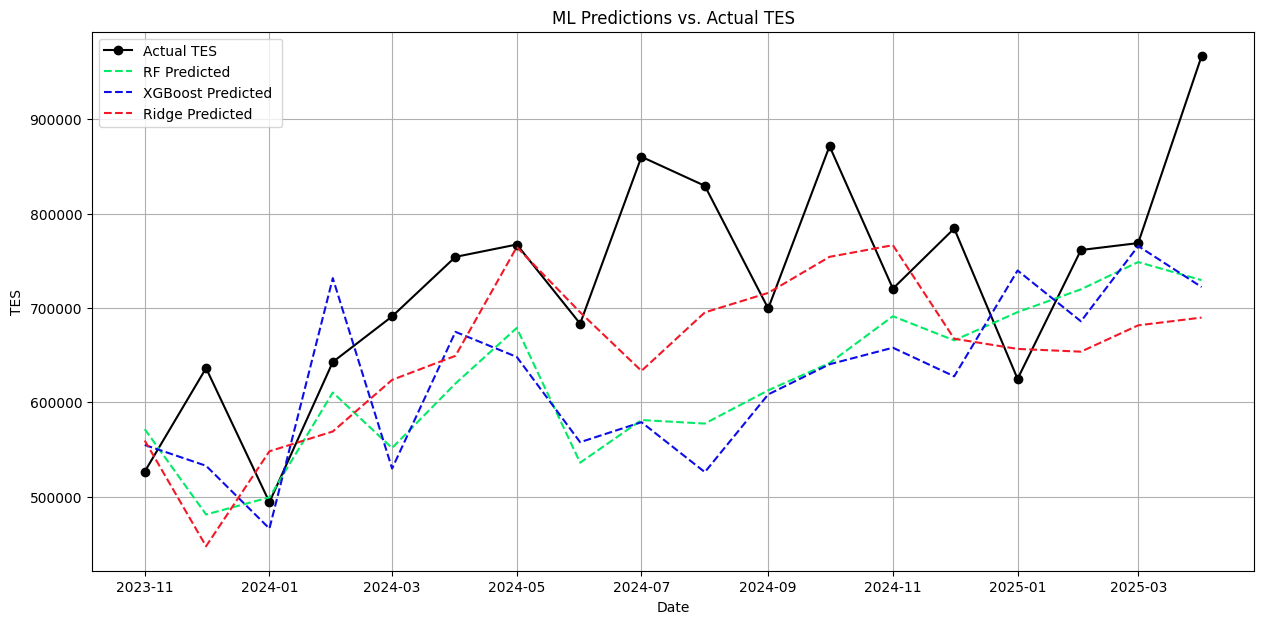

In [10]:
# Plot predictions vs. actuals
plt.figure(figsize=(15, 7))
plt.plot(results.index, results['actual'].values, label='Actual TES', marker='o', linestyle='-',color='black')
plt.plot(results.index, results['predicted_f'].values, label='RF Predicted ', linestyle='--', color="#03EA67")
plt.plot(results.index, results['predicted_x'].values, label='XGBoost Predicted ', linestyle='--', color="#0d0de7")
plt.plot(results.index, results['predicted_r'].values, label='Ridge Predicted ', linestyle='--', color="#f31826")

plt.title('ML Predictions vs. Actual TES')
plt.xlabel('Date')
plt.ylabel('TES')
plt.legend()
plt.grid(True)
plt.show()